In [1]:
import gym
import math
import random
import keras
import os
import tensorflow as tf
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.color import rgb2gray
from skimage.transform import rescale
from keras.models import Sequential, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Setting Global Parameters

class DQN_Agent(): 
    
    def __init__(self, num_state, num_action, params):
        
        self.params =  params
        self.num_state = num_state
        self.num_action = num_action
        self.steps = 0        
        self.gamma = params['gamma']   
        self.eps_min = params['eps_min']
        self.eps_max = params['eps_max']
        self.eps = params['eps_max']
        self.decay = params['decay']
        self.learning_rate = params['lr']
        self.batch_size = params['batch_size']
        self.capacity = params['capacity']
        self.load_model = params['load_model']
        self.model = self._create_model(load = self.load_model)
        self.memory=[]
        
    # Model OK    
    def _create_model(self, load = False):
        
        def huber_loss(y_true, y_pred, in_keras=True):
            err = y_true - y_pred
            quadratic_term = 0.5 * err**2
            linear_term = abs(err) - 1/2
            use_linear_term = (abs(err) > 1.0)
            
            if in_keras:
                use_linear_term = K.cast(use_linear_term, 'float32')
            return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term
            
        if not load:
            model =  Sequential()

            model.add(Conv2D(input_shape = self.num_state, filters = 32, 
                             kernel_size = 8, strides=2, 
                             activation = 'relu'))

            model.add(Conv2D(filters = 64, kernel_size = 4, strides=2, 
                             activation = 'relu'))

            model.add(Conv2D(filters = 64, kernel_size = 2, strides=1,
                             activation = 'relu'))

            model.add(Flatten()) 
            model.add(Dense(units=512, kernel_initializer='glorot_normal',
                            activation = 'relu')) 
            model.add(Dense(self.num_action))              

            optimizer = Adam(lr = self.learning_rate)
            model.compile(optimizer = optimizer, loss = huber_loss)

            print("Model constructed...", end ="\r", flush=True)
        else: 
            model = load_model('dqn.h5', custom_objects={'huber_loss' : huber_loss})
            print("Model loaded...", end ="\r", flush=True)
        
        return model   
    
    # Check OK
    def predict(self, state):        
        if len(state.shape) == 3:
            state = np.expand_dims(state, axis=0)
        return self.model.predict(state)
    
    # Check OK
    def observe(self, state, action, next_state, reward, done):
        self.memory.append((state, action, next_state, reward, done))    
        
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            
        self.eps = self.eps_min + (self.eps_max - self.eps_min) * math.exp(-self.steps * self.decay)        
        self.steps +=1        
        
    # Check OK    
    def act(self, state):      
        if np.random.rand() < self.eps:
            return np.random.choice(self.num_action)
        else:            
            return np.argmax(self.predict(state))                     
        
       
    def replay(self):
                
        batch_len = min(self.batch_size, len(self.memory))        
        batch = np.array(random.sample(self.memory, batch_len))        
        
        states = np.array([batch[i][0] for i in range(batch_len)])       
        next_states = np.array([(np.zeros(self.num_state) if episode[2] is None 
                                 else episode[2]) for episode in batch])
        action = np.array([batch[i][1] for i in range(batch_len)])
        reward = np.array([batch[i][3] for i in range(batch_len)])
        done = np.array([batch[i][4] for i in range(batch_len)])
                     
        q = self.predict(states)
        q_new = self.predict(next_states)
        
        y = np.zeros((batch_len, self.num_action)) 
        
        for i in range(batch_len):
            target = q[i]
            target[action] = reward[i] + self.gamma*np.max(q_new[i]) * (1-done[i]) 
            y[i] = target
            
        history = self.model.fit(states, y, verbose = 0, epochs=1, 
                                 shuffle = False, batch_size = self.batch_size) 
        mean_action_value = np.mean(np.mean(q))
        
        return history, mean_action_value
    

class input_pipeline():    
    
    def __init__(self, state):       
        self.history_length = 4        
        self.input_x=[]
        self.input_x = [self._preprocess(state) for i in range(self.history_length)]
        self.x = np.moveaxis(np.array(self.input_x), 0, -1) 

    def _preprocess(self, state):    
        
        state = np.mean(state, axis = 2).astype(np.uint8)
        state = state[::2, ::2]
        state = state[15:97,3:77]
        state[state==162] = 80
        state[state==180] = 90
        state[state==198] = 100
        state[state==200] = 110   
        return state / 255
    
    def update_state(self, state):
        self.input_x.pop(0)
        self.input_x.append(self._preprocess(state))
        self.x = np.moveaxis(np.array(self.input_x), 0, -1)
    


In [3]:
def main():
    
    env = gym.make('BreakoutDeterministic-v4')
    num_state = env.observation_space.shape    
    num_action = env.action_space.n
    
    agent = DQN_Agent((82,74,4), num_action, params)     
    
    loss, mean_av, render = [], [], False
    
    
    for episode in range(N_EPISODE):
        
        state, step, done, render = env.reset(), 0, False, False
        pipeline = input_pipeline(state)
       
        if episode > 0:
            render = True
        
        while not done:
            if render:
                env.render()

            action = agent.act(pipeline.x)            
            next_state, reward, done, _ = env.step(action)            

            x = pipeline.x
            pipeline.update_state(next_state)
            x_new = pipeline.x 
            step +=1
            
            if step >= 4 :    
                agent.observe(x, action, x_new, np.sign(reward), done)            
                history, mean_action_value = agent.replay()            

        # Boring housekeeping
        if episode % 10==0:
            agent.model.save('dqn.h5')    
            
        print('Episode {}/{}, Step:{}'.format(episode+1, N_EPISODE, step), end = '\r', flush = True) 

       

In [4]:
params = {}
params['gamma'] = 0.99
params['eps_min'] = 0.10
params['eps_max'] = 0.50
params['decay'] = 5e-5
params['batch_size'] = 64
params['lr'] = 0.00025
params['capacity'] = 5000
params['load_model'] = True

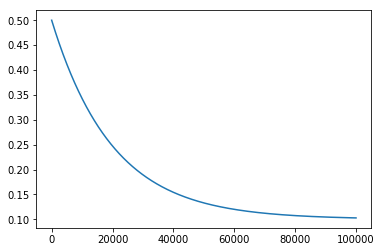

In [5]:
x = np.array(range(100000))
y = params['eps_min'] + (params['eps_max']-params['eps_min'])*np.exp(-params['decay']*x)
plt.plot(y)
plt.show()

In [ ]:
N_EPISODE = 10000000
main()

[2017-11-22 07:46:10,980] Making new env: BreakoutDeterministic-v4
